In [1]:
%matplotlib inline
import sys
import scipy as sp
import os
import pickle
import h5py
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import cm 
import gromics.viz.heatmap as hm

In [2]:
### constants
K = 41

In [3]:
### generate GTEx tissue dictionary from metadata
mfile = '/cluster/work/grlab/projects/GTEx/metadata/SraRunTable_20180218.txt'
metadata = sp.loadtxt(mfile, dtype='str', delimiter='\t')
metadata = metadata[1:, :]
metadata = metadata[:, [16, 23]]
metadict = dict([(x[0], x[1]) for x in metadata])

In [4]:
tissueID = dict([(x, i) for i, x in enumerate(sp.unique(metadict.values()))])
_, normalizers = sp.unique(metadict.values(), return_counts=True)

In [5]:
### prepare plotting dir
basedir = '/cluster/work/grlab/projects/metagenome/data/gtex'
plotdir = os.path.join(basedir, 'plots', 'queries_all_junctions.v2')
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [6]:
### load aggregated results
IN = h5py.File(os.path.join(basedir, 'queries', 'gencode.v30.all_junctions.result.hdf5'), 'r')
strains = sp.array([_.split('/')[-1] for _ in IN['strains'][:].view(sp.chararray).decode('utf-8')])
exons = IN['exons'][:].view(sp.chararray).decode('utf-8')

tissues = sp.array([metadict[_] for _ in strains])
tissues_u = sp.unique(tissues)

For all first exons, determine their lengths and the gene they are associated with. Also record the gene name for each gene.

In [7]:
### load query lengths
tlen_file = os.path.join(basedir, 'queries', 'gencode.v30.all_junctions.len.tsv')
exons2len = dict()
exons2genes = dict()
genes2exons = dict()
for line in open(tlen_file, 'r'):
    sl = line.strip().split('\t')
    exons2len[sl[0]] = int(sl[1])
    gene = sl[2].split(';')[0].rsplit(':', 2)[0]
    exons2genes[sl[0]] = gene
    try:
        genes2exons[gene].append(sl[0])
    except KeyError:
        genes2exons[gene] = [sl[0]]
#exon_lens = sp.array([exons2len[_] for _ in exons])
genes = sp.array([exons2genes[_] for _ in exons])
gene_names = sp.array([_.split(':')[1] for _ in genes])

For each junction, we have aggregated the results in the input hdf5 now accessed via `IN`. Here, `IN['matching']` stores for each junction, how many kmers matched per GTEx sample, while `IN['expression']` stores the total expression of each kmer in each sample. Hence `IN['expression'][i, j] / exon_lens[i]` is the everage expression of exon `i` in sample `j` and `IN['expression'][i, j] / IN['matching'][i, j]` is the everage count per matching kmer for exon `i` in sample `j`.

We denote an exon as `is_expressed`, if on average we expression of 1 per kmer in the exon (`expression > (exon_lens - K + 1)`).

In [8]:
### get mean tissue expression and matching per tissue
expression = IN['expression'][:]

In [10]:
### remove junctions that are
### 1: unexpressed
### 2: are in a gene with only one transcript annotated
#num_kmers = exon_lens[:, sp.newaxis] - K + 1
#num_kmers[num_kmers < 1] = 1
num_kmers = 2*(K-1)
is_expressed = (expression / num_kmers > 0.1)
kidx1 = sp.sum(is_expressed, axis=1) > 0
kidx2 = sp.array([len(genes2exons[_]) > 1 for _ in genes]) 
#kidx3 = (exon_lens >= K)
kidx = kidx1 & kidx2

expression = expression[kidx, :]
is_expressed = is_expressed[kidx]
exons = exons[kidx]
#exon_lens = exon_lens[kidx]
#num_kmers = num_kmers[kidx]
genes = genes[kidx]
gene_names = gene_names[kidx]
genes_u = sp.unique(genes)

In [14]:
mean_expression = sp.zeros((expression.shape[0], tissues_u.shape[0]), dtype='float')
is_expressed_fraction = sp.zeros((expression.shape[0], tissues_u.shape[0]), dtype='float')
for i, tissue in enumerate(tissues_u):
    t_idx = sp.where(tissues == tissue)[0]
    e_idx = is_expressed[:, t_idx]
    mean_expression[:, i] = sp.mean(expression[:, t_idx], axis=1) / num_kmers
    is_expressed_fraction[:, i] = sp.sum(e_idx, axis=1) / t_idx.shape[0]
del expression

In [19]:
### remove all genes that are not expressed in all tissues 
### (as we are after differential junction usage and not differential gene expression)
kidx = sp.zeros((mean_expression.shape[0],), dtype='bool')
for gene in gene_names:
    gidx = sp.where(gene_names == gene)[0]
    kidx[gidx] = (sp.sum(mean_expression[gidx, :].max(axis=0) > 0) == mean_expression.shape[1])

mean_expression = mean_expression[kidx, :]
is_expressed = is_expressed[kidx]
exons = exons[kidx]
#exon_lens = exon_lens[kidx]
#num_kmers = num_kmers[kidx]
genes = genes[kidx]
gene_names = gene_names[kidx]
genes_u = sp.unique(genes)

In [ ]:
### find best matching rows (more then 90%)
#matching = IN['matching'][:]
#matching = matching[kidx, :]
#mean_matching = sp.zeros((matching.shape[0], tissues_u.shape[0]), dtype='float')
#for i, tissue in enumerate(tissues_u):
#    t_idx = sp.where(tissues == tissue)[0]
#    mean_matching[:, i] = sp.mean(matching[:, t_idx], axis=1) / (exon_lens - K + 1)
#best_matching = matching.max(axis=1) / (exon_lens - K + 1)
#min_matching = mean_matching.min(axis=1)
#max_matching = mean_matching.max(axis=1)

In [21]:
### get genes of interest
rmsd_max = []
coord_max = []
for gene in genes_u:
    gidx = sp.where(genes == gene)[0]
    #curr = mean_expression[gidx, :] * mean_matching[gidx, :]
    curr = mean_expression[gidx, :]
    rmsd = [0]
    coords = [[0, 0]]
    for i in range(curr.shape[0]):
        for j in range(i + 1, curr.shape[0]):
            if min(curr[i, :].max(), curr[j, :].max()) < 0.2:
                continue
            if max(curr[i, :].min(), curr[j, :].min()) > 0.5:
                continue
            z = curr[i, :] - curr[j, :]
            rmsd.append(sp.sqrt(sp.dot(z, z.T) / z.shape[0]))
            coords.append([i, j])
    r = sp.argmax(sp.array(rmsd))
    rmsd_max.append(rmsd[r])
    coord_max.append(coords[r])

In [ ]:
s_idx = sp.argsort(rmsd_max)[::-1]
i = s_idx[2]
gidx = sp.where(genes == genes_u[i])[0]
cmax = coord_max[i]
mean_expression[gidx, :][cmax[1]]

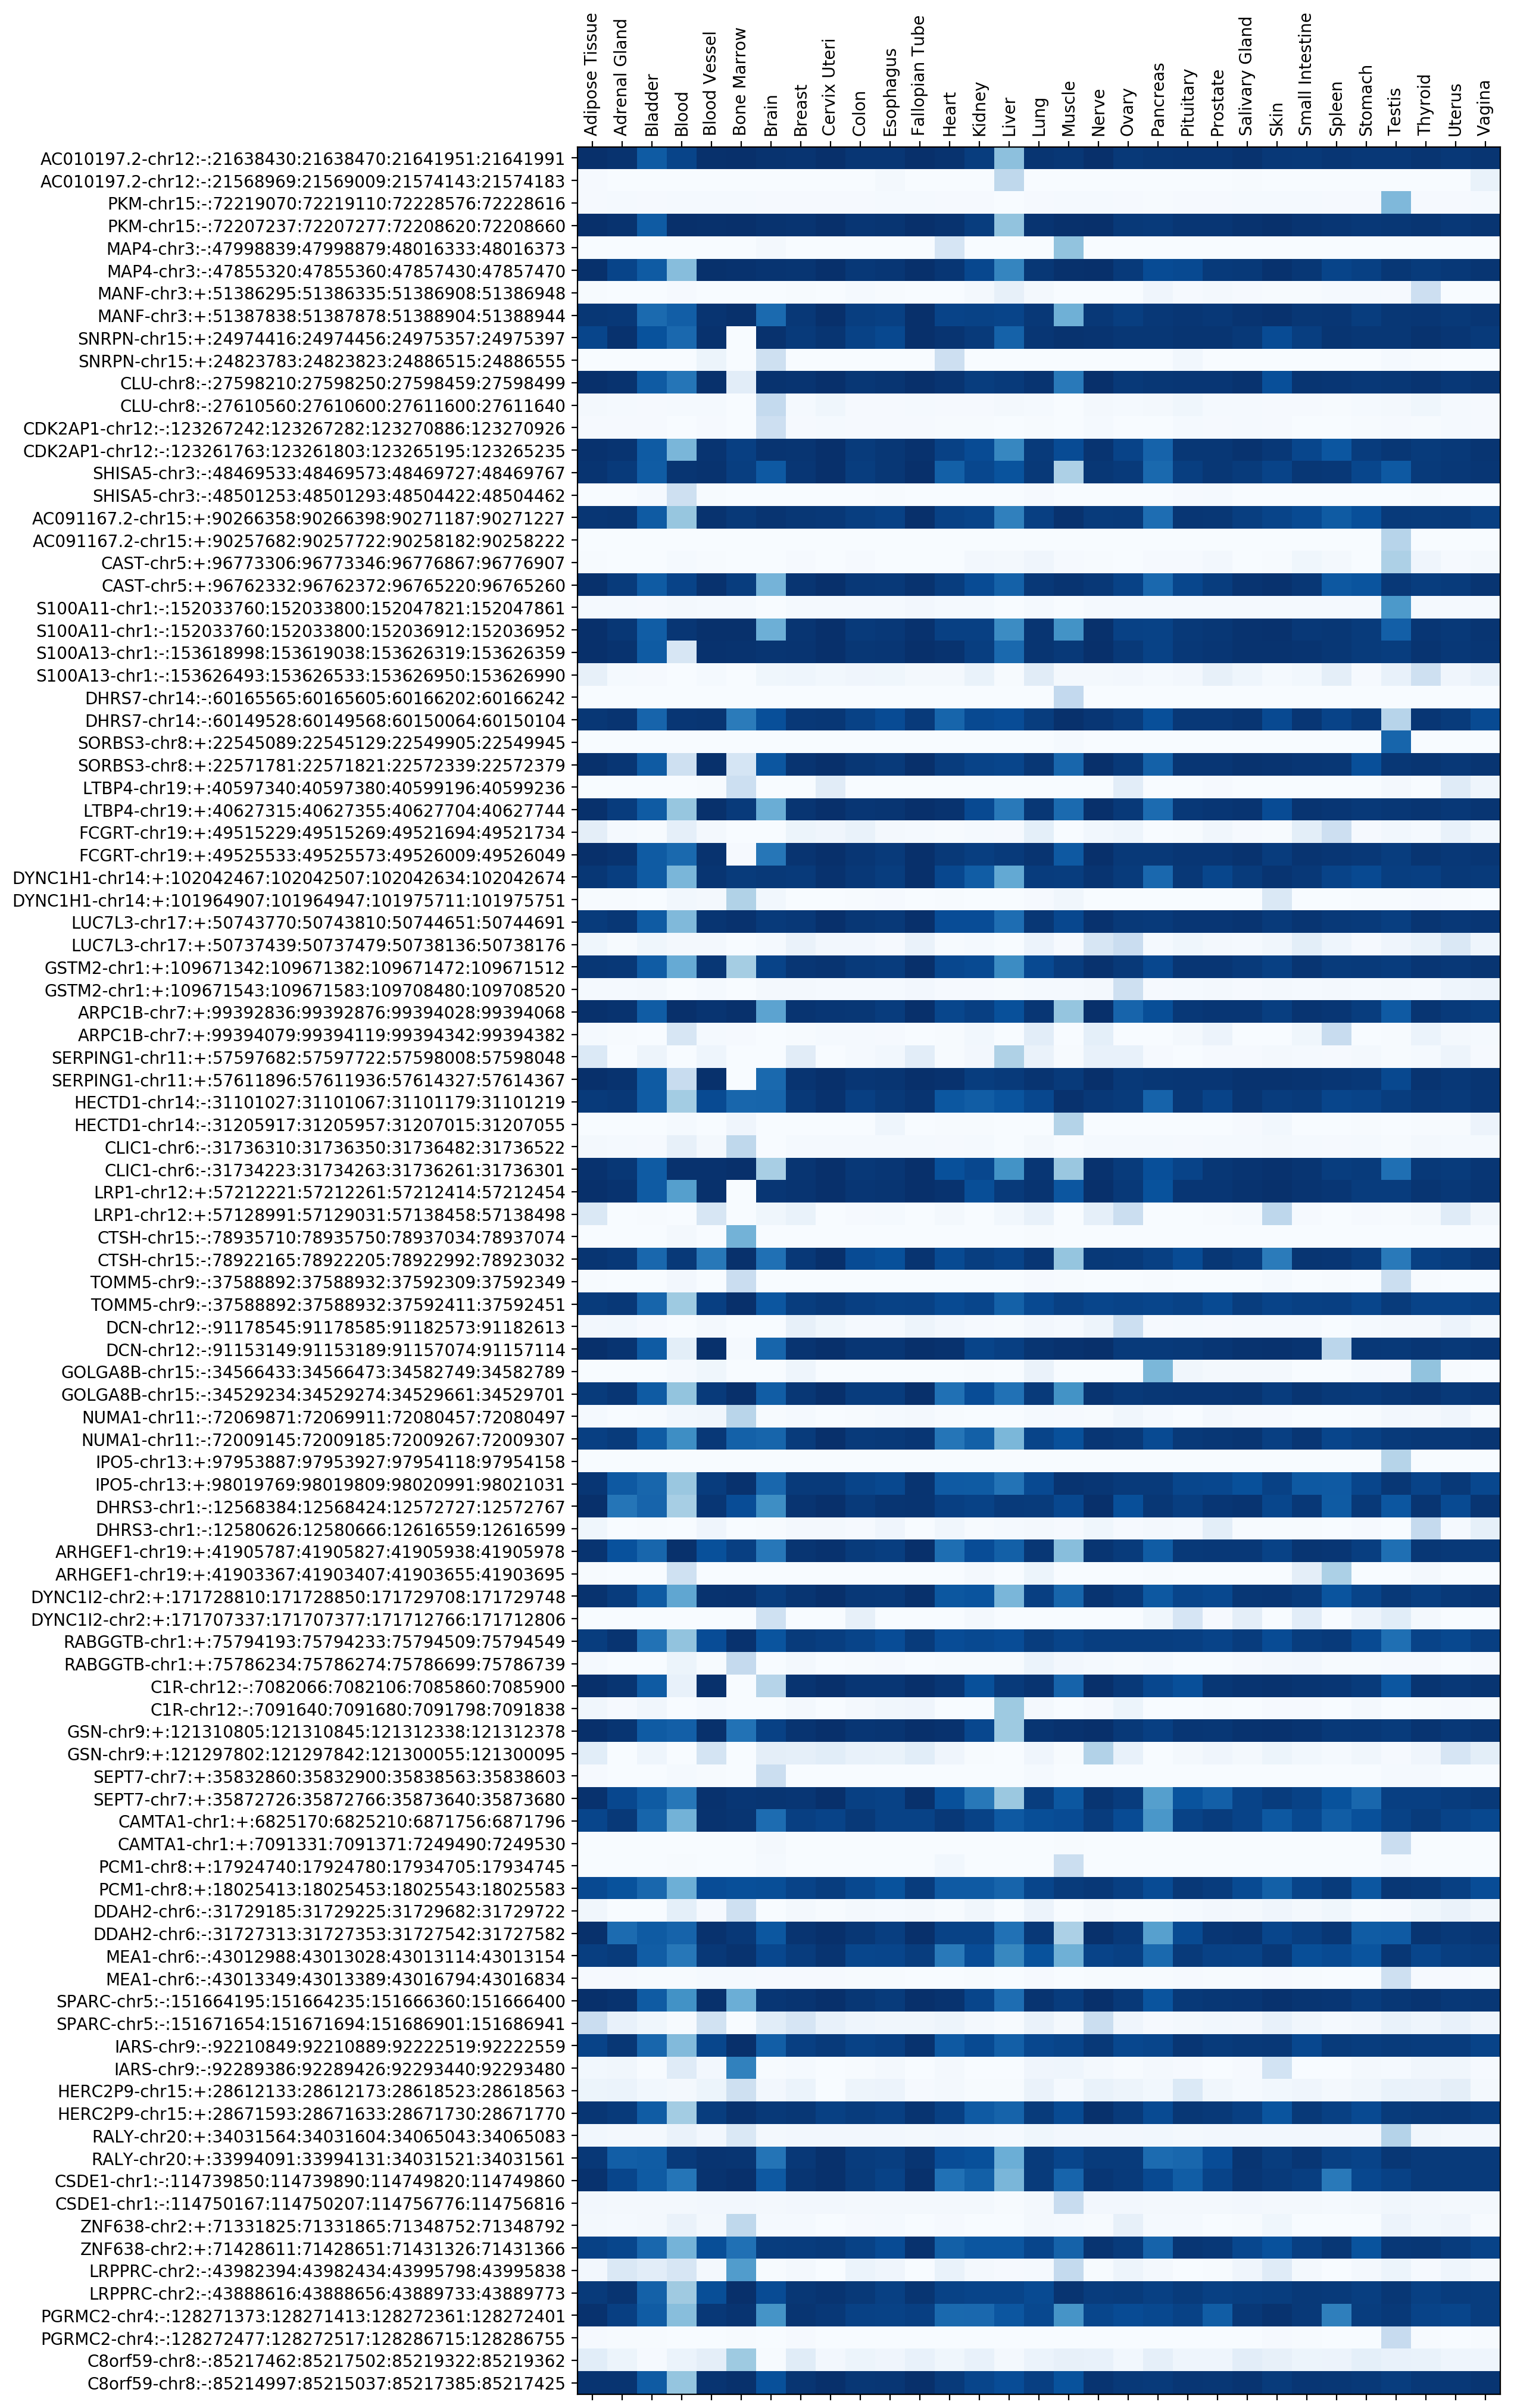

In [22]:
### plotting
FROM = 0
TO = 50
pmatrix = []
glabels = []
elabels = []
s_idx = sp.argsort(rmsd_max)[::-1]
for i in s_idx[FROM:TO]:
    gidx = sp.where(genes == genes_u[i])[0]
    cmax = coord_max[i]
    #pmatrix.append((mean_expression[gidx, :] * mean_matching[gidx, :])[cmax])
    pmatrix.append(mean_expression[gidx, :][cmax])
    glabels.append(genes[gidx][cmax])
    elabels.append(exons[gidx][cmax])
pmatrix = sp.vstack(pmatrix)
elabels = sp.hstack(elabels)
glabels = sp.hstack(glabels)

fig = plt.figure(figsize=(10, 25), dpi=200)
ax = fig.add_subplot(111)
ax.matshow(pmatrix.astype('float'), aspect='auto', cmap=cm.Blues)
ax.set_xticks(sp.arange(pmatrix.shape[1]))
ax.set_xticklabels(tissues_u, rotation=90)
ax.set_yticks(sp.arange(pmatrix.shape[0]))
ylabels = sp.array(['-'.join([glabels[_].split(':')[-1], elabels[_]]) for _ in range(elabels.shape[0])])
ax.set_yticklabels(ylabels)
plt.show()

In [23]:
groups = sp.ones((pmatrix.shape[0] // 2,), dtype='int') * 2
cmap_group = sp.array([cm.Blues for _ in range(pmatrix.shape[0] // 2)])
norm_group = sp.array([plt.Normalize(0, pmatrix.max()) for _ in range(pmatrix.shape[0] // 2)])

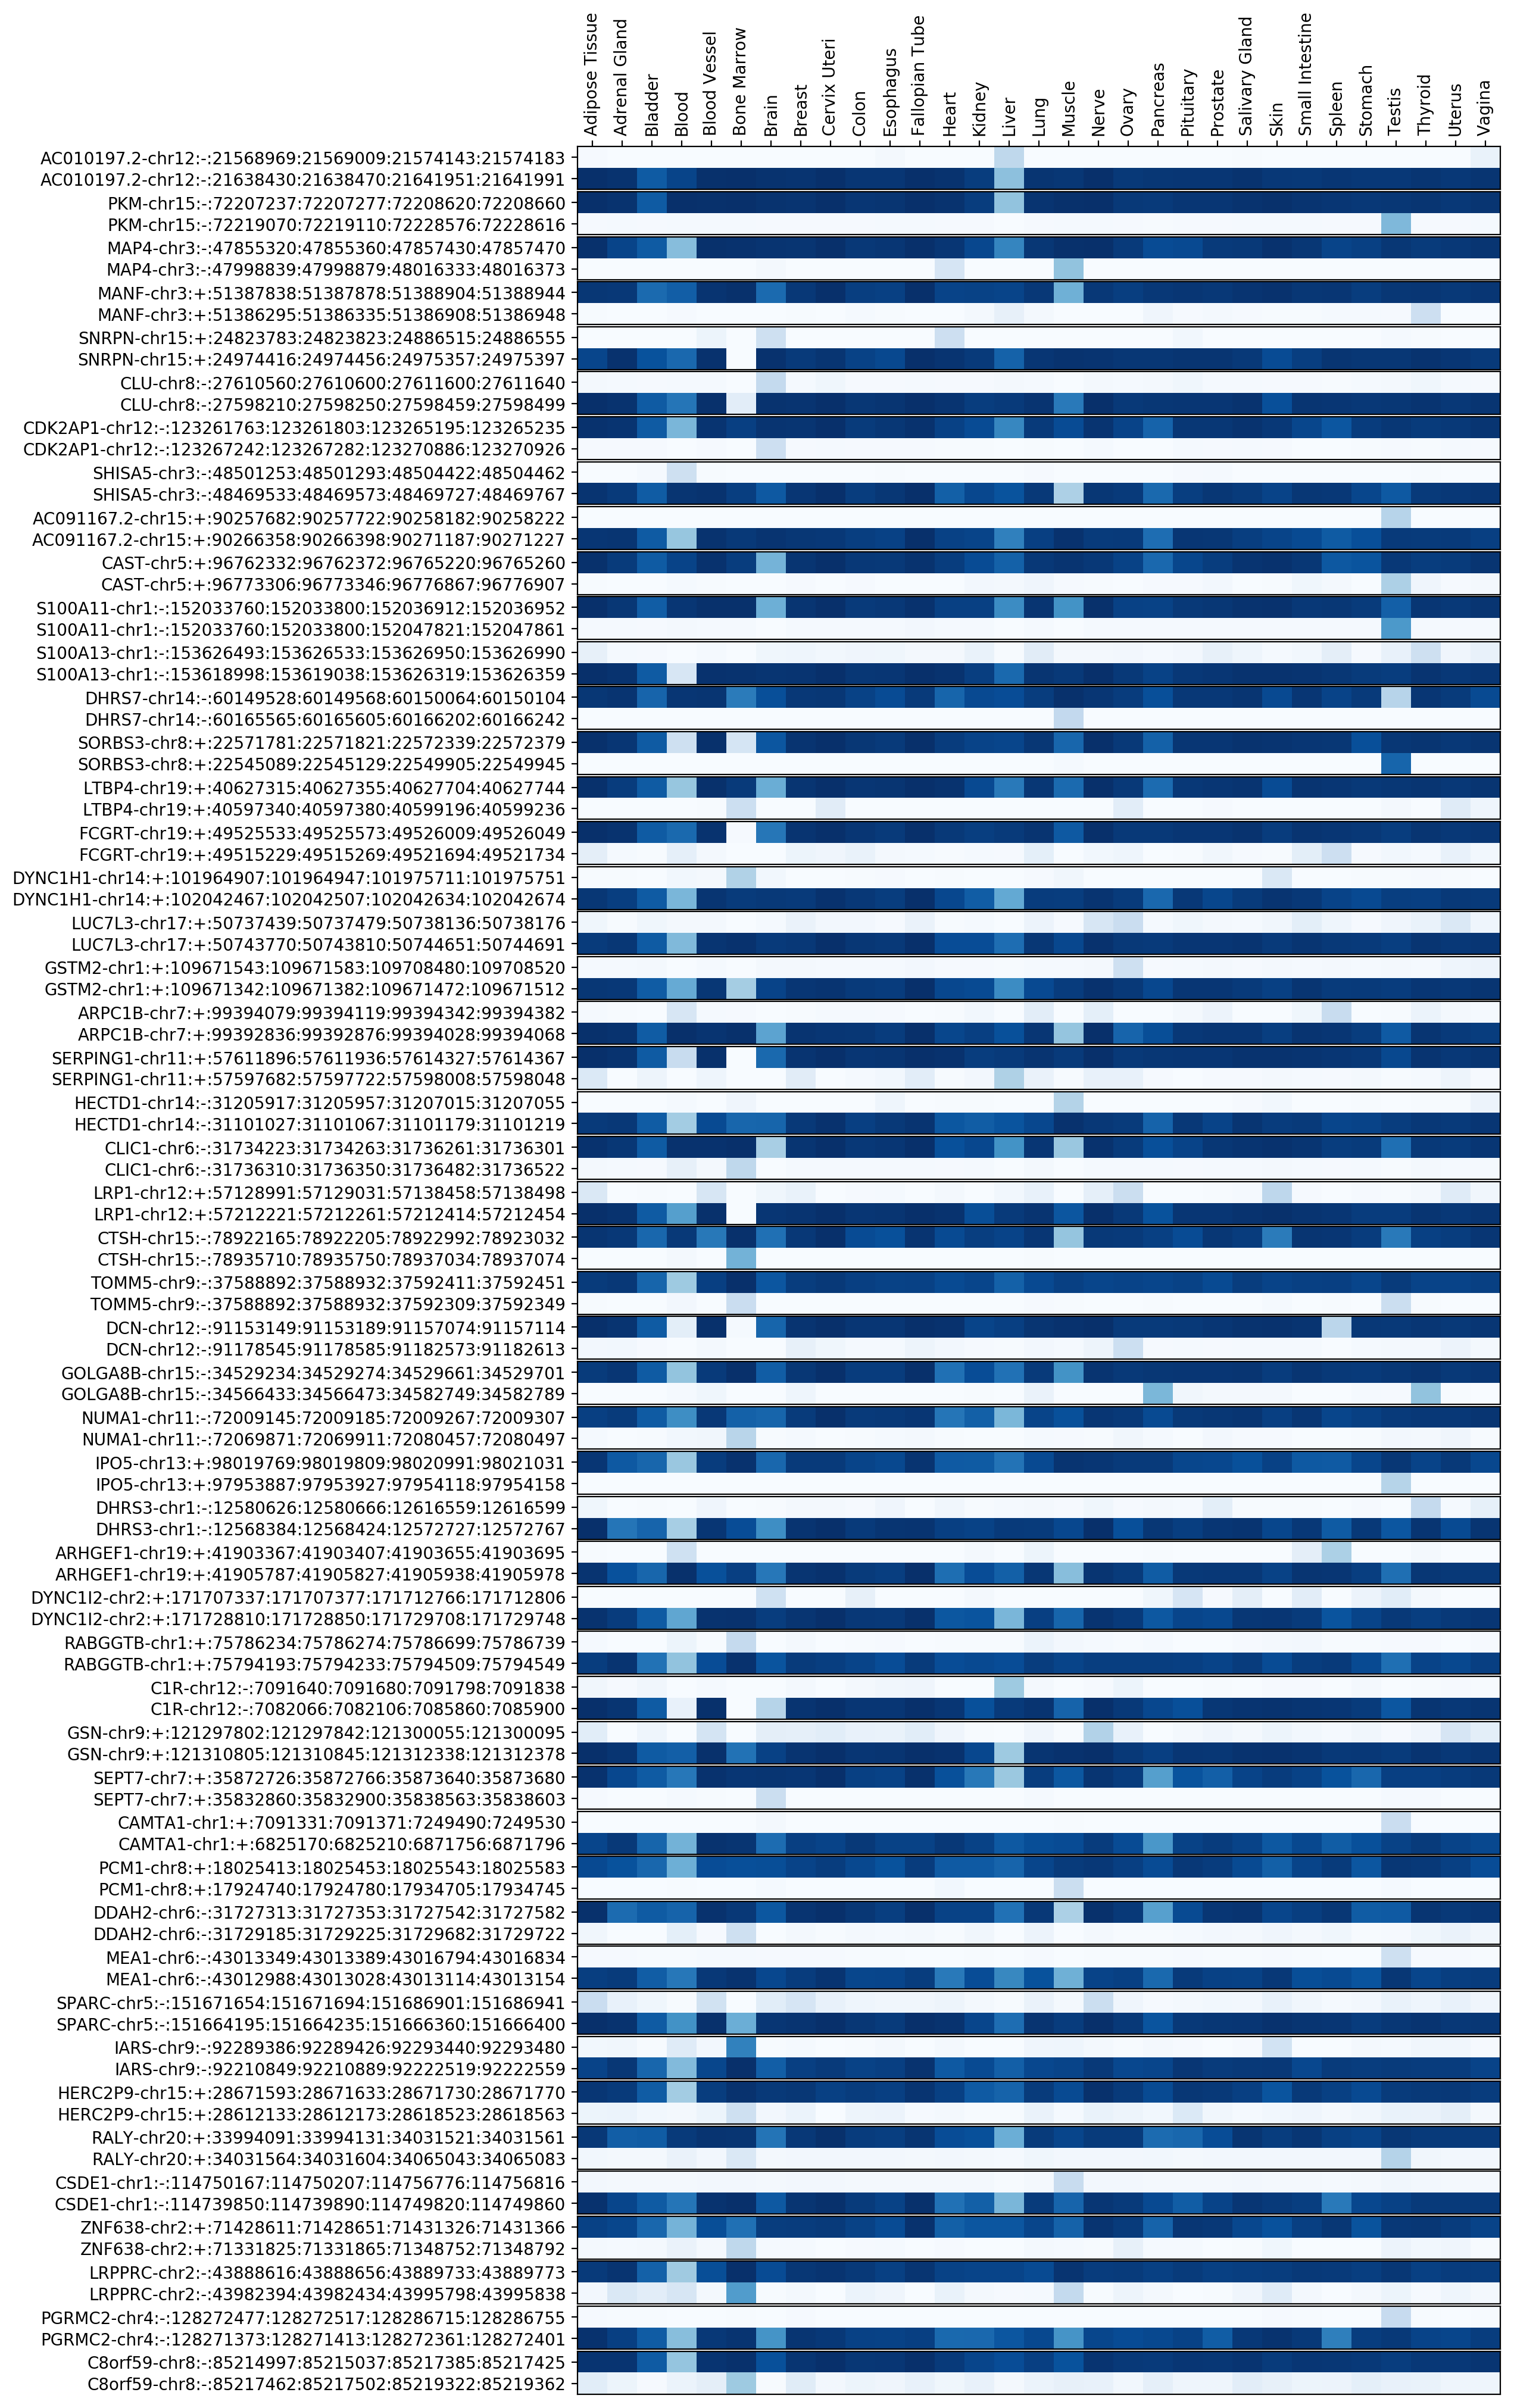

In [24]:
fig = plt.figure(figsize=(10, 25), dpi=200)
(fig, axes) = hm.trackPlot(pmatrix, fig, groups=groups, labels=ylabels, cmap=cmap_group, norm=norm_group)
axes[0].xaxis.tick_top()
axes[0].set_xticks(sp.arange(pmatrix.shape[1]))
axes[0].set_xticklabels(tissues_u, rotation=90)
plt.show()